In [3]:
import os
import time
import refl1d
from refl1d.names import *
from bumps import dream

import numpy as np

from matplotlib import pyplot as plt

%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

## Accumulator class

In [4]:
class Accumulator(object):
    def __init__(self, name='', z_min=-10, z_max=450, z_step=2.0, is_magnetic=True):
        self.z = np.arange(z_min, z_max, z_step)
        self.z_mid = [(self.z[i+1]+self.z[i])/2.0 for i in range(len(self.z)-1)]
        self.summed = np.zeros(len(self.z)-1)
        self.sq_summed = np.zeros(len(self.z)-1)
        self.m_summed = np.zeros(len(self.z)-1)
        self.m_sq_summed = np.zeros(len(self.z)-1)
        self.counts = np.zeros(len(self.z)-1)
        self.z_step = z_step
        self.name = name
        self.is_magnetic = is_magnetic

    def add(self, z, rho, rhoM):
        """ Add a model to the average """
        if rhoM is None:
            self.is_magnetic = False

        z_ = np.asarray(z)
        rho_ = np.asarray(rho[:-1])
        r_out = refl1d.rebin.rebin(z_, rho_, self.z)

        # Compute the average step size so we can normalize after rebinning
        average_step = np.asarray([z[i+1]-z[i] for i in range(0, len(z)-2, 2) if z[i]>0]).mean()
        r_out = r_out * average_step / self.z_step

        self.summed += r_out
        self.sq_summed += r_out * r_out

        if self.is_magnetic:
            rhoM_ = np.asarray(rhoM[:-1])
            rM_out = refl1d.rebin.rebin(z_, rhoM_, self.z)
            rM_out = rM_out * average_step / self.z_step
            self.m_summed += rM_out
            self.m_sq_summed += rM_out * rM_out
        _counts = [ 1*(z>z_[0] and z<z_[-1]) for z in self.z[:-1] ]
        self.counts += _counts

    def mean(self):
        _counts = np.asarray([ 1 if c==0 else c for c in self.counts ])
        avg = self.summed / _counts
        sq_avg = self.sq_summed / _counts
        sig = np.sqrt(sq_avg - avg*avg)

        return self.z_mid, avg, sig

    def mean_magnetism(self):
        if not self.is_magnetic:
            return self.z_mid, np.zeros(len(self.z_mid)), np.zeros(len(self.z_mid))

        _counts = np.asarray([ 1 if c==0 else c for c in self.counts ])
        avg = self.m_summed / _counts
        sq_avg = self.m_sq_summed / _counts
        sig = np.sqrt(sq_avg - avg*avg)

        return self.z_mid, avg, sig

## Function to load MC data and compute the SLD profile with uncertainties
Loading can be very slow, consider using trim=True

In [15]:
def load_bumps(file_path, problem, trim=False, state=None, z_max=450.0):
    """
        Use bumps to load MC
    """
    model_list = [problem]
    if hasattr(problem, '_models'):
        model_list = problem._models

    acc = [Accumulator(m.fitness.name,z_min=-50, z_max=z_max) for m in model_list]
    
    t0 = time.time()
    if state is None:
        state = dream.state.load_state(file_path)
    state.mark_outliers()

    # If we have a population, only pick 1000 of them
    if trim and state.draws>1000:
        print("Too many points: pruning down to 1000")
        portion = 1000.0 / state.draws
        drawn = state.draw(portion=portion)

    print("MC file read: %s sec" % (time.time()-t0))
    pts = np.asarray(drawn.points)

    for i, p in enumerate(pts):
        problem.setp(p)
        # Loop over models (Experiments)
        for j, model in enumerate(model_list):
            if model.fitness.ismagnetic:
                z, r, _, rM, _ = model.fitness.magnetic_smooth_profile()
                acc[j].add(z, r, rM)
            else:
                z, r, _ = model.fitness.smooth_profile()
                acc[j].add(z, r, None)

    print("Done %s sec" % (time.time()-t0))
    return acc

In [16]:
#file_path = os.path.expanduser('~/git/refl1d_analysis/playground/matfit/model152both')
file_path = '/SNS/users/m2d/reflectivity_fits/IPTS-24925/178261/__model'

# Load the model that was used for fitting
code = open(file_path+'.py', 'r').read()
exec(code)

state = dream.state.load_state(file_path)
acc_data = load_bumps(file_path, problem, state=state, trim=True, z_max=750.)

Too many points: pruning down to 1000
MC file read: 0.011066198348999023 sec
Done 6.165982246398926 sec


<IPython.core.display.Javascript object>


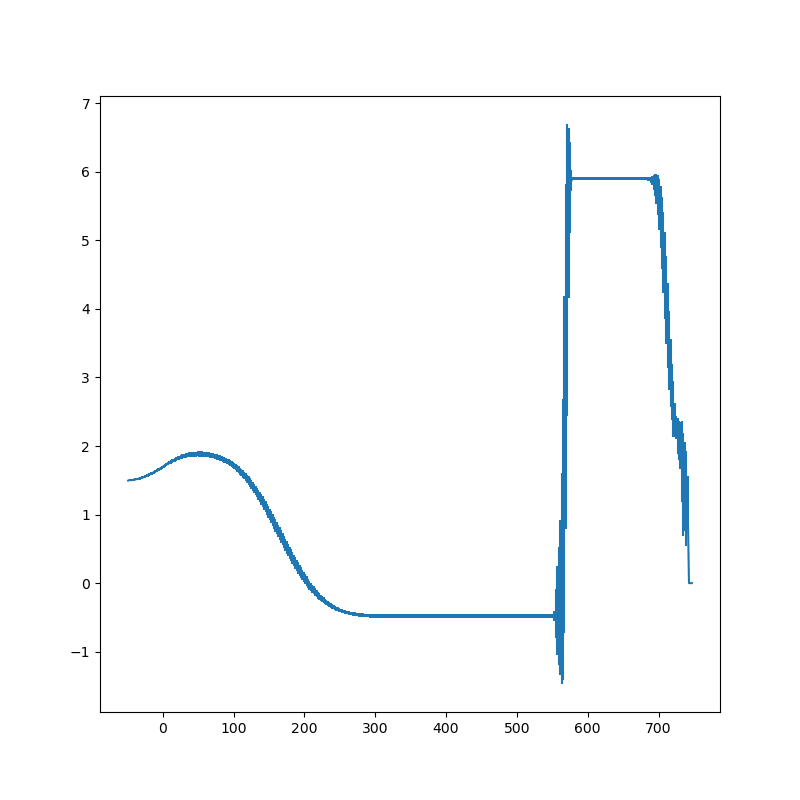

In [31]:
plot_data = []
data_names = []

fig, ax = plt.subplots(figsize=(8,8))

for i, _acc in enumerate(acc_data):
    z, sld, dsld = _acc.mean()
    z, msld, dmsld = _acc.mean_magnetism()

    plt.errorbar(z, sld, dsld, label='SLD [%s] %s' % (i, _acc.name))


## Load the MC results to look at parameter distributions

In [20]:
file_path = '/SNS/users/m2d/reflectivity_fits/IPTS-24925/178261/__model'

state = dream.state.load_state(file_path)
state.mark_outliers()
drawn = state.draw()
pts = np.asarray(drawn.points)
#state.show()

## Load the model used
We will use it to get the reflectivity curve and the names of the parameters

In [23]:
code = open(file_path+'.py', 'r').read()
exec(code)
model_pars = problem.labels()

In [24]:
import bumps.dream.stats
all_vstats = dream.stats.var_stats(drawn)

In [25]:
import bumps.dream.views
print(bumps.dream.views.format_vars(all_vstats))

              Parameter       mean  median    best [   68% interval] [   95% interval]
 1                   P0 2.15(24)e-6 0.000002143 0.000001964 [0.00000191 0.00000240] [0.00000168 0.00000263]
 2                   P1 0.9938(62)  0.9957  0.9994 [  0.988   0.999] [  0.977   1.000]
 3                   P2   26.8(45)   26.45   25.94 [   22.3    31.1] [   18.9    36.8]
 4                   P3   47.4(16)  47.362  48.524 [  45.83   48.98] [  44.45   50.57]
 5                   P4  1.919(47)   1.918   1.930 [   1.87    1.97] [   1.83    2.01]
 6                   P5  165.1(51)  165.31  167.51 [  160.3   170.0] [  154.3   174.4]
 7                   P6  1.074(70)   1.054   1.003 [   1.01    1.14] [   1.00    1.26]
 8                   P7 -0.485(32)  -0.485  -0.486 [  -0.52   -0.45] [  -0.55   -0.42]
 9                   P8  402.9(21) 402.942 402.416 [ 400.88  404.96] [ 398.75  406.85]
10                   P9   7.42(18)   7.428   7.413 [   7.25    7.60] [   7.08    7.76]
11                  P1

## Generate the histrograms

In [26]:
def make_logp_histogram(draw, ci, nbins=30):

    values = draw.points[:, 5].flatten()
    logp = draw.logp
    weights = draw.weights
    
    if weights is None:
        weights = np.ones_like(logp)

    # TODO: values are being sorted to collect stats and again to plot
    idx = np.argsort(values)
    values, weights, logp = values[idx], weights[idx], logp[idx]

    edges = np.linspace(ci[0], ci[1], nbins+1)
    idx = np.searchsorted(values[1:-1], edges)
    weightsum = np.cumsum(weights)

    heights = np.diff(weightsum[idx])/weightsum[-1]  # normalized weights
    
    points = np.asarray(drawn.points)
    vmin,vmax = -np.max(logp),-np.min(logp)
    

    bins = []  # marginalized maximum likelihood
    for h, s, e, xlo, xhi \
            in zip(heights, idx[:-1], idx[1:], edges[:-1], edges[1:]):
        if s == e:
            continue
        pv = -logp[s:e]

        pidx = np.argsort(pv)
        
        pw = weights[s:e][pidx]

        x = np.array([xlo, xhi], 'd')
        y = np.hstack((0, np.cumsum(pw)))
        z = pv[pidx][:, None]

        # centerpoint, histogram height, maximum likelihood for each bin
        bins.append(((xlo+xhi)/2, y[-1], np.exp(vmin-z[0])))
        

    # Check for broken distribution
    if not bins:
        return
    centers, height, maxlikelihood = np.array(bins).T
    # Normalize maximum likelihood plot so it contains the same area as the
    # histogram, unless it is really spikey, in which case make sure it has
    # about the same height as the histogram.
    maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
    hist_peak = np.max(height)
    
    ml_peak = np.max(maxlikelihood)
    if ml_peak > hist_peak*1.3:
        maxlikelihood *= hist_peak*1.3/ml_peak
    return centers, height, maxlikelihood
    


In [27]:
param_id = 5
ci = all_vstats[param_id].p95_range
print("95%% CL range for this parameter: %s" % str(ci))

values, heights, prob = make_logp_histogram(drawn, ci)

95% CL range for this parameter: (154.27539779167822, 174.35132517423116)


<IPython.core.display.Javascript object>


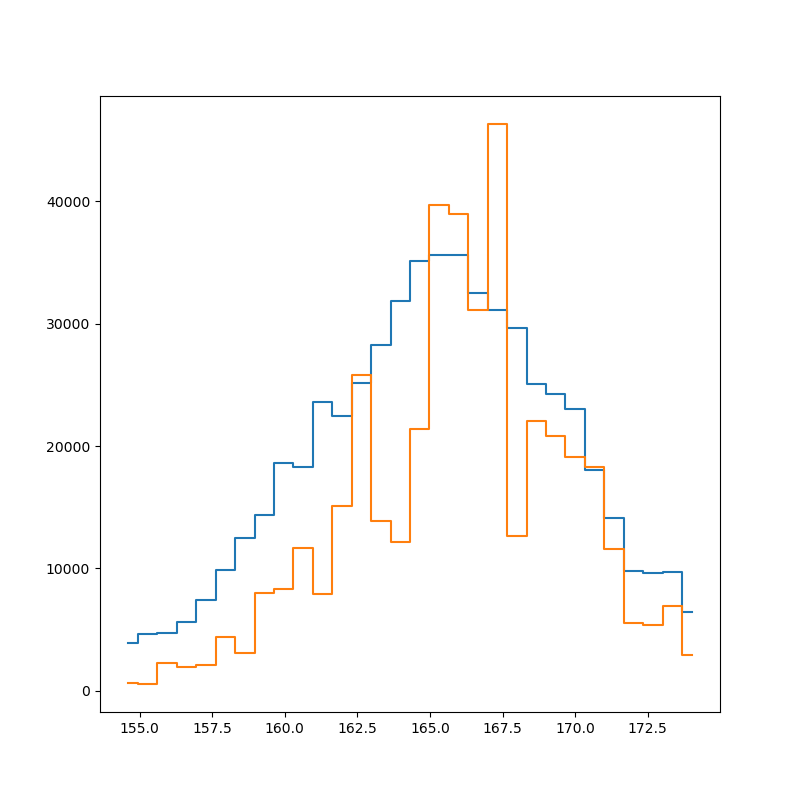

(30,) (30,)


In [36]:
fig, ax = plt.subplots(figsize=(8,8))
plt.step(values, heights, where='mid')
plt.step(values, prob, where='mid')

print(values.shape, heights.shape)

## Plot parameter distribution and correlation

<IPython.core.display.Javascript object>


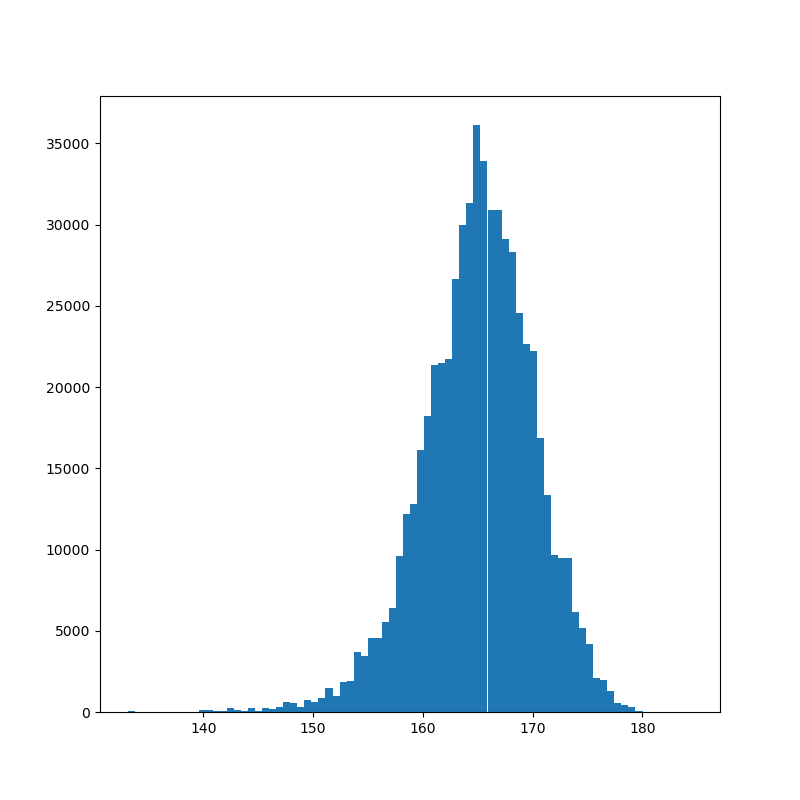

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
_ = plt.hist(pts.T[5], bins=80)


<IPython.core.display.Javascript object>


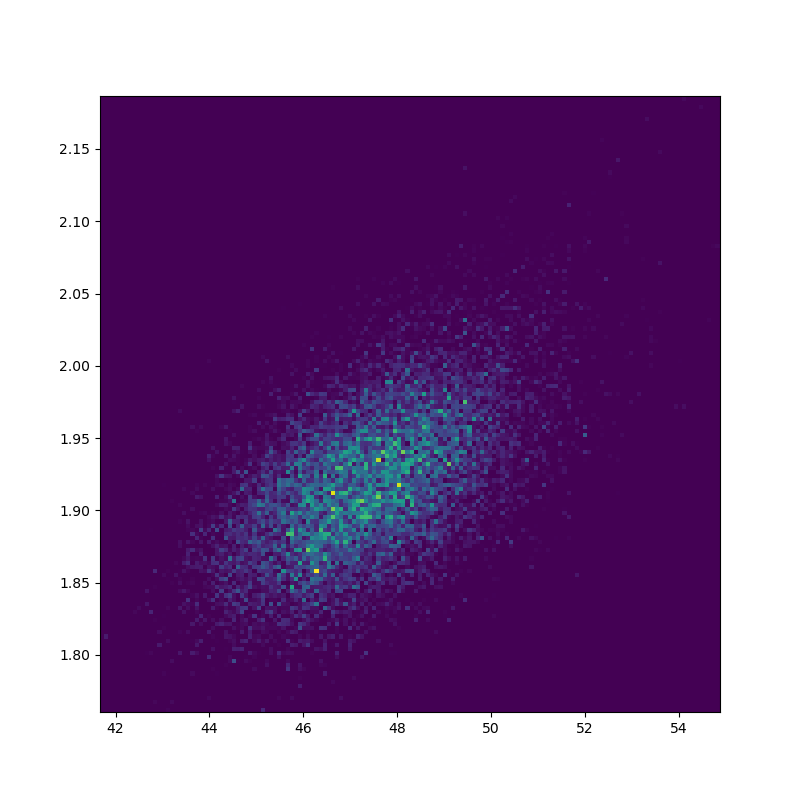

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
_ = plt.hist2d(pts.T[3], pts.T[4], bins=150)

## Loading at MC file directly into bumps

In [46]:
state = dream.state.load_state(file_path)

In [57]:
print("Number of parameters: %s" % state.Nvar)
#state.show()

Number of parameters: 12


## Plot reflectivity from the model file
Update it using the best fit result

<IPython.core.display.Javascript object>


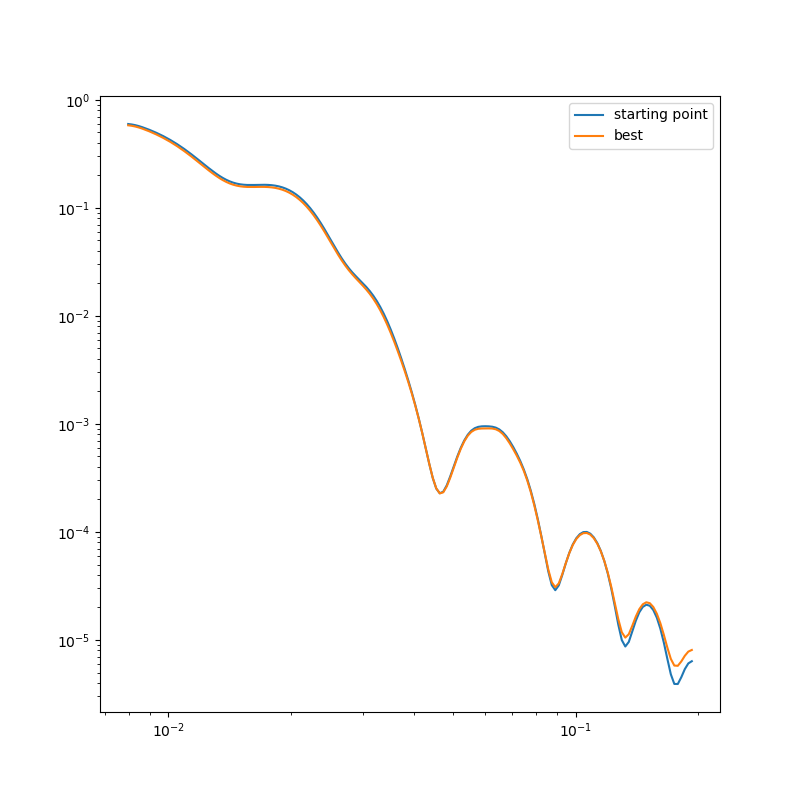

In [56]:
# Load the model used
code = open(file_path+'.py', 'r').read()
exec(code)

def _extract_reflectivity(_problem, model_id=0, name=''):
    plot_data = []
    data_names = []    
    if hasattr(problem, '_models'):
        _model = _problem._models[model_id]
    else:
        _model = _problem

    ref_data = _model.fitness.reflectivity()
    if not _model.fitness.ismagnetic:
        plot_data.append([ref_data[0], ref_data[1]])
        data_names.append(name)
    else:
        for i, _ref in enumerate(ref_data):
            if _ref is not None:
                plot_data.append([_ref[0], _ref[1]])
                data_names.append('%s %s' % (name, i+1))
    return plot_data, data_names

plot_data, data_names = _extract_reflectivity(problem, name='starting point')

# Update with the best fit result
best_pars, _ = state.best()
problem.setp(best_pars)

fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(plot_data)):
    plt.loglog(plot_data[i][0], plot_data[i][1], label=data_names[i])

_plot_data, _data_names = _extract_reflectivity(problem, name='best')
for i in range(len(_plot_data)):
    plt.loglog(_plot_data[i][0], _plot_data[i][1], label=_data_names[i])
plt.legend()


## Testing things out...

In [ ]:
# Load the model used
code = open(file_path+'.py', 'r')
exec code

pars = best_pars #pts[1160]
problem.setp(pars)

acc = Accumulator(z_max=600.0)

# Do something different if we did a simultaneous fit.
if hasattr(problem, '_models'):
    # This is a magnetic sample example
    z, r, _, rM, _ = problem._models[1].fitness.magnetic_smooth_profile()
    acc.add(z,r,rM)
else:
    # This is a non-magnetic sample example
    z, r, _ = problem.fitness.smooth_profile()
    acc.add(z,r,r)


_z, _sld, _dsld = acc.mean()
_z, _m_sld, _d_m_sld = acc.mean_magnetism()

plot_utils.plot1d([[_z, _sld, _dsld],
                   [_z, _m_sld, _d_m_sld],
                   [z, r]],
                    data_names = ['sld', 'm_sld', 'direct'])